# DSCI 100 Group Project Report

## Predicting Prize Money for Male Tennis Players


## Loading Libraries

In [177]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

### Introduction

Tennis is a widely appreciated and watched game worldwide. There are more than 1 billion tennis fans [1] who follow the sport and desire to access player statistics over time, like how many matches a player won, what is the winning ratio of a player against his rivals, what is the winning pattern of a player on various kinds of surface, and many more questions. Tennis stats are very limited and one of the best platforms for tennis statistics is “Ultimate Tennis Statistics”. [2]

In this work, we will attempt to determine the best variables that can be used to predict the prize money that a player will win at a stage of their career.

For this work, the data was downloaded from Ultimate Tennis Statistics. [3] This data contains various information summarized for the top 500 male tennis players. The data contains 38 variables about the players. These variables are of either continuous and categorical types. The continuous variables include age, prize money, current rank, best rank, height, weight, and more, while the categorical variables include backhand (two handed or one handed), plays (left hand or right hand) and favorite surface (clay, grass, hard slow, soft and all-rounder), and more.

Importantly, the data is not clean; thus, it needs proper cleaning before starting other analyses. For example, there are some cells with no values, so we will delete those observations as a part of data cleaning. The column names of the data are spaced, so we will fix them accordingly. Finally, we will use the best variables we find of the cleaned data as the explanatory variable to predict prize money (response variable) using the appropriate regression model.

### Loading Data From Web

In [188]:
# Dataset read into R.

url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"

player_stats <- read_csv(url, show_col_types = FALSE)
print("Table 1: Player Stats (head)")
head(player_stats) 

New names:
• `` -> `...1`


[1] "Table 1: Player Stats (head)"


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Preliminary Exploratory Data Analysis

In [179]:
print("Table 2: Number of NAs per Variables")
na_count <- colSums(is.na(player_stats))
na_count


na_count_frame <- data.frame(variable = names(na_count), na_count = unname(na_count))

na_count_frame <- na_count_frame |>
    arrange(na_count) |>
    filter(variable == "Age" | variable == "Best Rank" | variable == "Current Rank" | variable == "Current Elo Rank" | 
          variable == "Best Elo Rank" | variable == "Titles" | variable == "Seasons" | variable == "GOAT Rank" |
           variable == "Olympics" | variable == "Weeks at No. 1" | variable == "Tour Finals" | variable == "Peak Elo Rating")

print("Table 3: Number of Numerical Variable NAs (head)")
head(na_count_frame)
print("Table 4: Number Numerical Variable of NAs (Tail)")
tail(na_count_frame)

[1] "Table 2: Number of NAs per Variables"


...1              Age          Country            Plays 
               0                1                1               47 
       Wikipedia     Current Rank        Best Rank             Name 
               1                5                1                0 
        Backhand      Prize Money           Height Favorite Surface 
              92               81              385              259 
      Turned Pro          Seasons           Active Current Elo Rank 
             254              126              218              316 
   Best Elo Rank  Peak Elo Rating  Last Appearance           Titles 
             263              263              158              405 
       GOAT Rank      Best Season          Retired          Masters 
             399              399              420              484 
      Birthplace        Residence           Weight            Coach 
             480              480              480              481 
        Facebook          Twitter        Nicknames      Grand Slams 
             483              481              488              493 
      Davis Cups         Web Site        Team Cups         Olympics 
             468              461              494              498 
  Weeks at No. 1      Tour Finals 
             496              494

[1] "Table 3: Number of Numerical Variable NAs (head)"


,variable,na_count
,<chr>,<dbl>
1,Age,1
2,Best Rank,1
3,Current Rank,5
4,Seasons,126
5,Best Elo Rank,263
6,Peak Elo Rating,263


[1] "Table 4: Number Numerical Variable of NAs (Tail)"


,variable,na_count
,<chr>,<dbl>
7,Current Elo Rank,316
8,GOAT Rank,399
9,Titles,405
10,Tour Finals,494
11,Weeks at No. 1,496
12,Olympics,498


### Selecting Predictor Variables To Test

There are a total of 38 variables in the data, but many of them have numerous missing values (NA), as you can see from our list/dataframe above. There were some variables that are not suitable for the prediction of prize money, such as twitter, nickname and birthplace, therefore we removed all categorical variables. Additionally, we observed the number of NAs in the suitable numeric variables. To maintain a decent size of the data for our analysis, we removed those numeric variables with too many missing values. These variables being Seasons, Peak Elo Rating, Best Elo Rank, Current Elo Rank, GOAT Rank, Titles, Tour Finals, Weeks at No. 1 and Olympics, based on the tables above. We were left with Age, Current Rank, Best Rank. Finally, we will be checking to see if age, current rank and best rank will be good predictors for our model.

### Cleaning and Wrangling Data

In [180]:
#Fixed titles and changed the types
player_stats <- player_stats |>
    rename_all(~ gsub(" ", "_", .)) 

# Selecting the needed the columns (Age, Best_Rank, Prize_Money), 
# Filtering out rows which don't have any prize money won,
# Changing the column types to correct type
# Getting rid of the date of births and the best_rank dates from both columns. 
# Getting rid of everything besides the number in the Prize_Money column  

player_stats_tidy <- player_stats |> 
    select(Age, Current_Rank, Best_Rank, Prize_Money) |>
    filter(!is.na(Prize_Money)) |>
    filter(!is.na(Age)) |>
    filter(!is.na(Current_Rank)) |>
    filter(!is.na(Best_Rank)) |>
    mutate(Age = as.integer(sub("\\s*\\(.*\\)", "", Age))) |>
    mutate(Best_Rank = as.integer(sub("\\s*\\(.*\\)", "", Best_Rank))) |>
    mutate(Prize_Money = gsub("\\$", "", Prize_Money)) |>
    mutate(Prize_Money = gsub("US", "", Prize_Money)) |>
    mutate(Prize_Money = gsub("[^0-9]", "", Prize_Money)) |>
    mutate(Prize_Money = as.numeric(Prize_Money)) |>
    mutate(Current_Rank = gsub("\\(.*\\)", "", Current_Rank)) |>
    mutate(Current_Rank = as.integer(Current_Rank))

print("Table 5: Player Stats Tidy Data Frame")
player_stats_tidy

[1] "Table 5: Player Stats Tidy Data Frame"


Age,Current_Rank,Best_Rank,Prize_Money
<int>,<int>,<int>,<dbl>
18,326,316,59040
32,178,44,3261567
21,236,130,374093
⋮,⋮,⋮,⋮
20,382,380,57943
26,5,4,2213236815
22,451,408,61984


## Removing Outliers

Warning message:
“Removed 19 rows containing missing values (geom_point).”


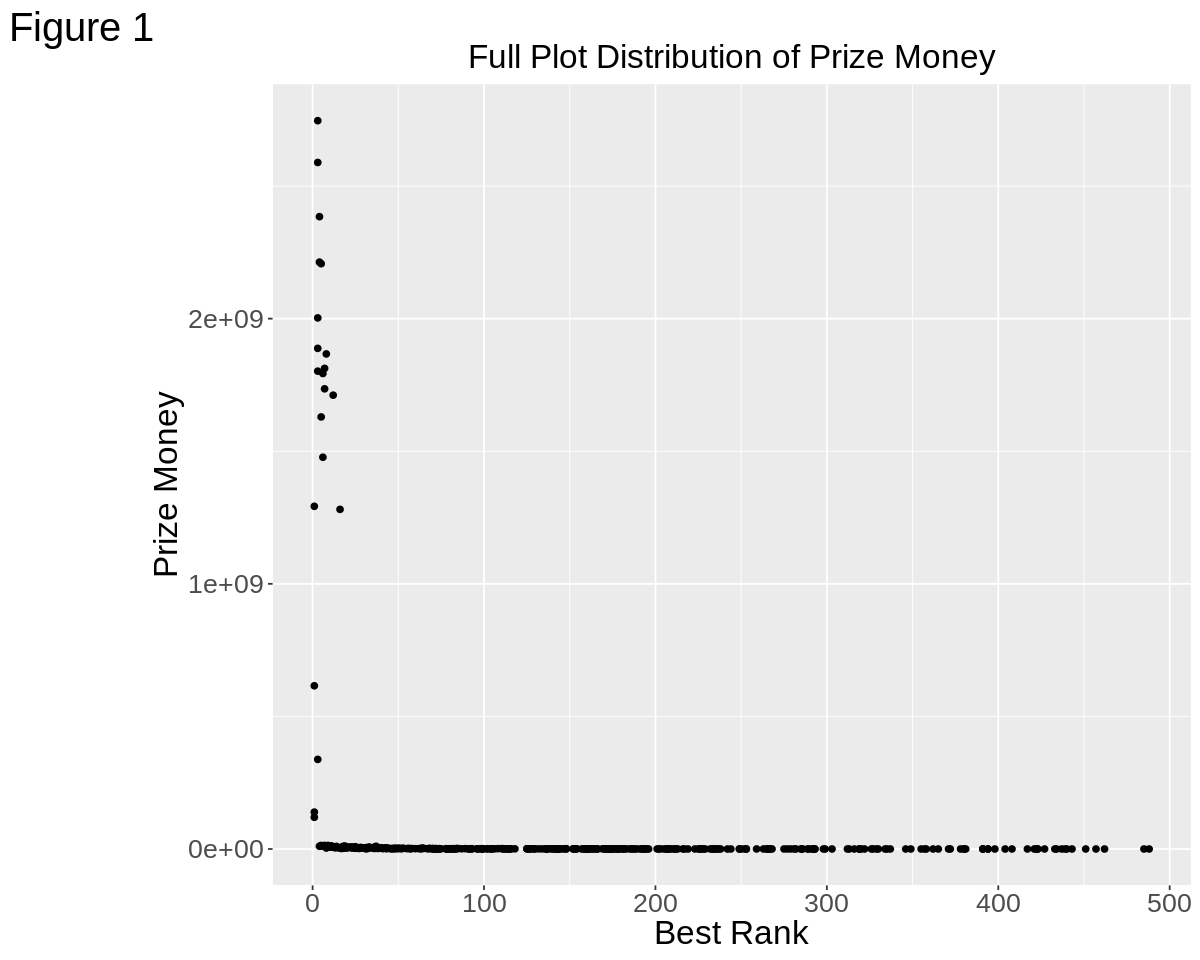

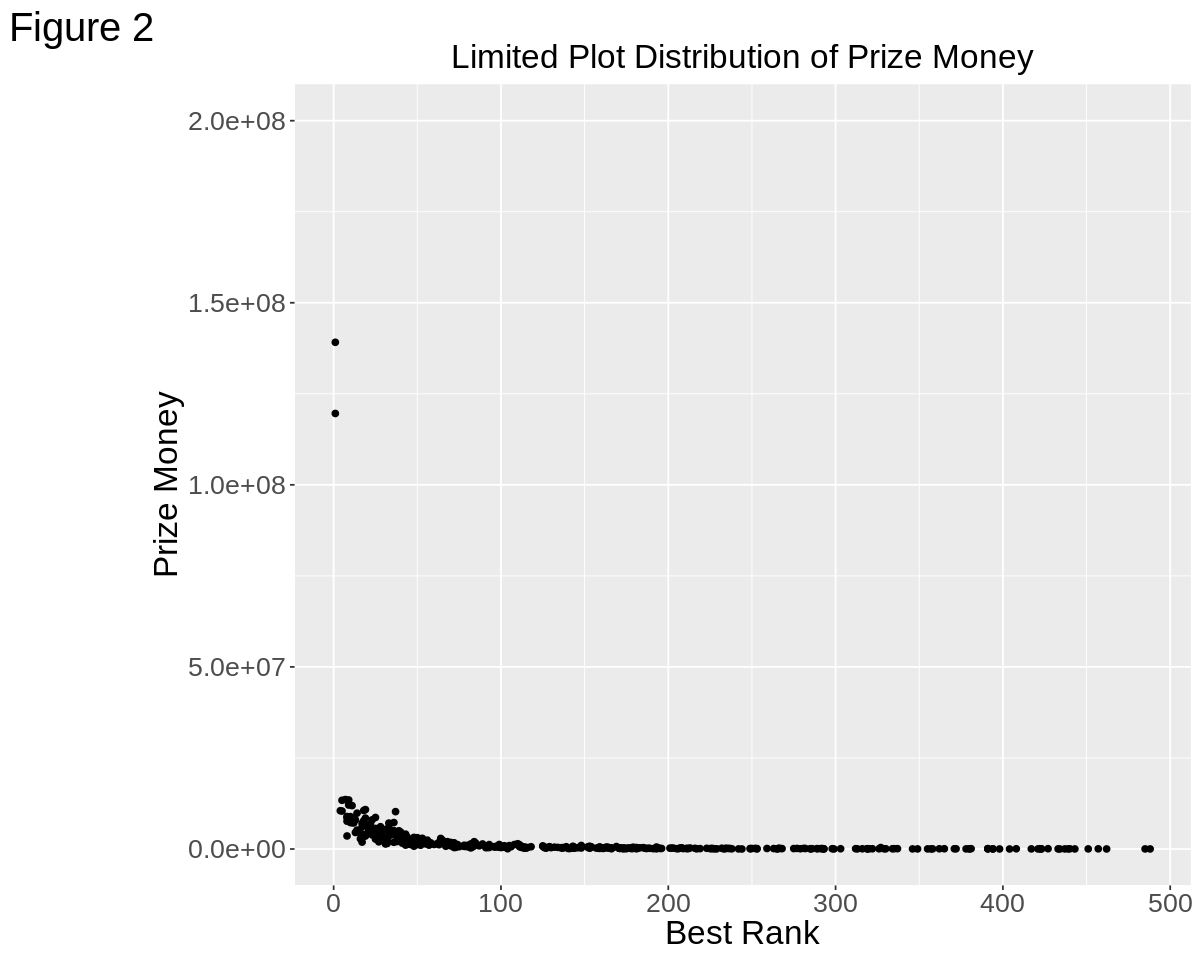

In [181]:
plot_outliers_orig <- player_stats_tidy|>
    ggplot(aes(x = Best_Rank, y = Prize_Money))+
    geom_point()+
    labs(x = "Best Rank", y = "Prize Money", tag = "Figure 1")+
    theme(text = element_text(size = 20))+
    ggtitle("Full Plot Distribution of Prize Money")+
    theme(plot.title = element_text(size = 20, hjust = 0.5))

plot_outliers_orig

plot_outliers <- player_stats_tidy|>
    ggplot(aes(x = Best_Rank, y = Prize_Money))+
    geom_point()+
    labs(x = "Best Rank", y = "Prize Money", tag = "Figure 2")+
    theme(text = element_text(size = 20))+
    ylim(c(0, 200000000)) +
    ggtitle("Limited Plot Distribution of Prize Money")+
    theme(plot.title = element_text(size = 20, hjust = 0.5))

plot_outliers

We visualized a scatterplot of prize money vs best rank that shows that there are many outliers towards the high end of prize money. As you can see from the first plot there are many outliers above 1 billion USD and from the second plot we can see the last few outliers being above 100 million USD. Therefore we will filter for prize money < 100 million USD to reduce the prediction error of our model.

In [182]:
write_csv(player_stats_tidy, "player_stats_tidy.csv")

In [183]:
set.seed(2000) ### DO NOT CHANGE

player_stats_tidy <- player_stats_tidy |>
    filter(Prize_Money < 100000000)

# Data split into training and testing again with new tidy data.

player_stats_split <- initial_split(player_stats_tidy, prop = 0.75, strata = Prize_Money)
player_stats_training <- training(player_stats_split)
player_stats_testing <- testing(player_stats_split)

## Data Summarized in tables

[1] "Table 6: Max Prize Money"


Prize_Money
<dbl>
13578010


[1] "Table 7: Min Prize Money"


Prize_Money
<dbl>
2893


[1] "Table 8: Average Total Prize Money Won for every Age Group"


Age,Prize_Money
<int>,<dbl>
17,14340.0
18,182125.6
19,287551.0
⋮,⋮
37,13376235
38,4927689
40,9845365


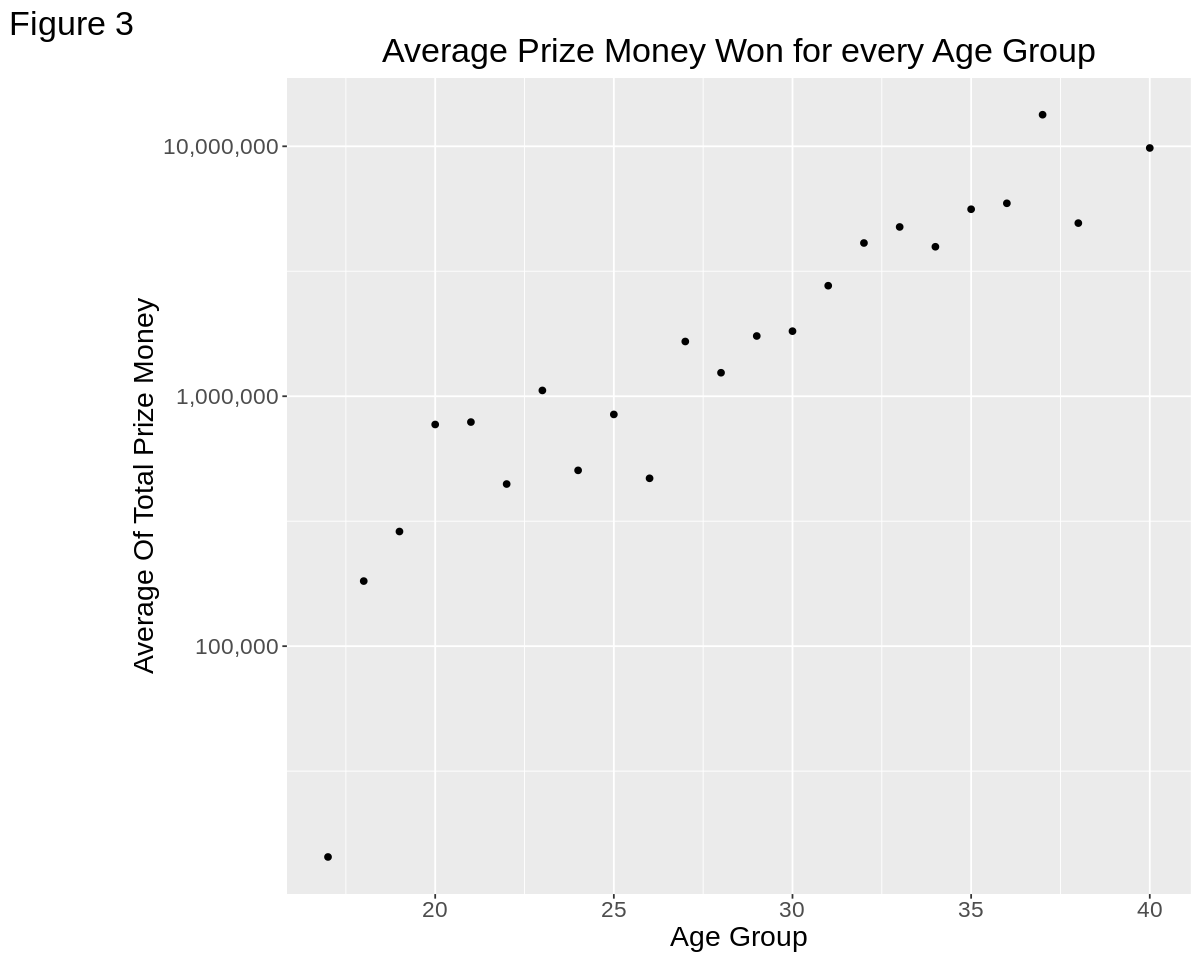

In [184]:
#Using only training data, summarize the data in at least one table.
options(repr.plot.height = 8, repr.plot.width = 12)

max_prize_money <- player_stats_training |>
    select(Prize_Money) |>
    arrange(desc(Prize_Money)) |>
    slice(1)

print("Table 6: Max Prize Money")
max_prize_money

min_prize_money <- player_stats_training |>
    select(Prize_Money) |>
    arrange(Prize_Money) |>
    slice(1)

print("Table 7: Min Prize Money")
min_prize_money


# Average Total Prize Money Won for every Age group.
print("Table 8: Average Total Prize Money Won for every Age Group")
average_age_prize_money <- player_stats_training |> 
    group_by(Age) |> 
    summarize(Prize_Money = mean(Prize_Money))

average_age_prize_money

options(repr.plot.height = 8, repr.plot.width = 10)
# Scatter plot showing the Average Total Prize Money won for every Age group. 
average_age_prize_money_plot <- average_age_prize_money |>
    ggplot(aes(x = Age, y = Prize_Money)) + 
    geom_point() +
    xlab("Age Group") + 
    ylab("Average Of Total Prize Money") + 
    labs(tag = "Figure 3" , title = "Average Prize Money Won for every Age Group") +
    scale_y_log10(labels = label_comma()) + 
    theme(text = element_text(size=17), plot.title = element_text(hjust = 0.5))

average_age_prize_money_plot


### Summary Of Data Tables


The most prize money won is 13,578,010 USD (filtered prize money) and the least prize money won (excluding NA) is 2893 USD. All the y-axes of graphs in the preliminary data analysis are scaled using log10 to account for prize money increases drastically towards the larger values. 
The table “Average Total Prize Money Won for every Age Group” groups tennis players by age and then the mean prize money of each age group is computed. The scatter plot shows a general trend of greater average prize money won as the age group increases. 




## Visualizations

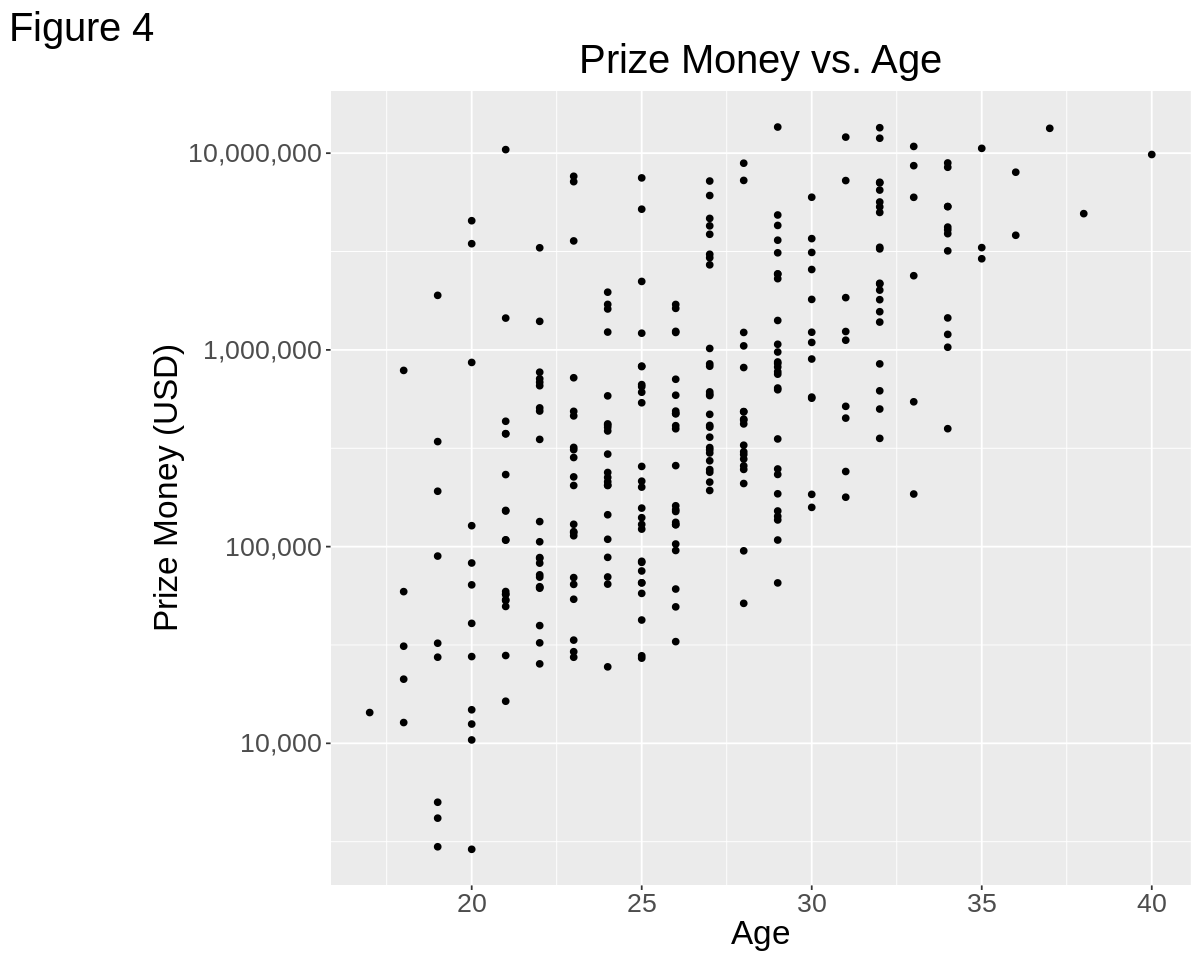

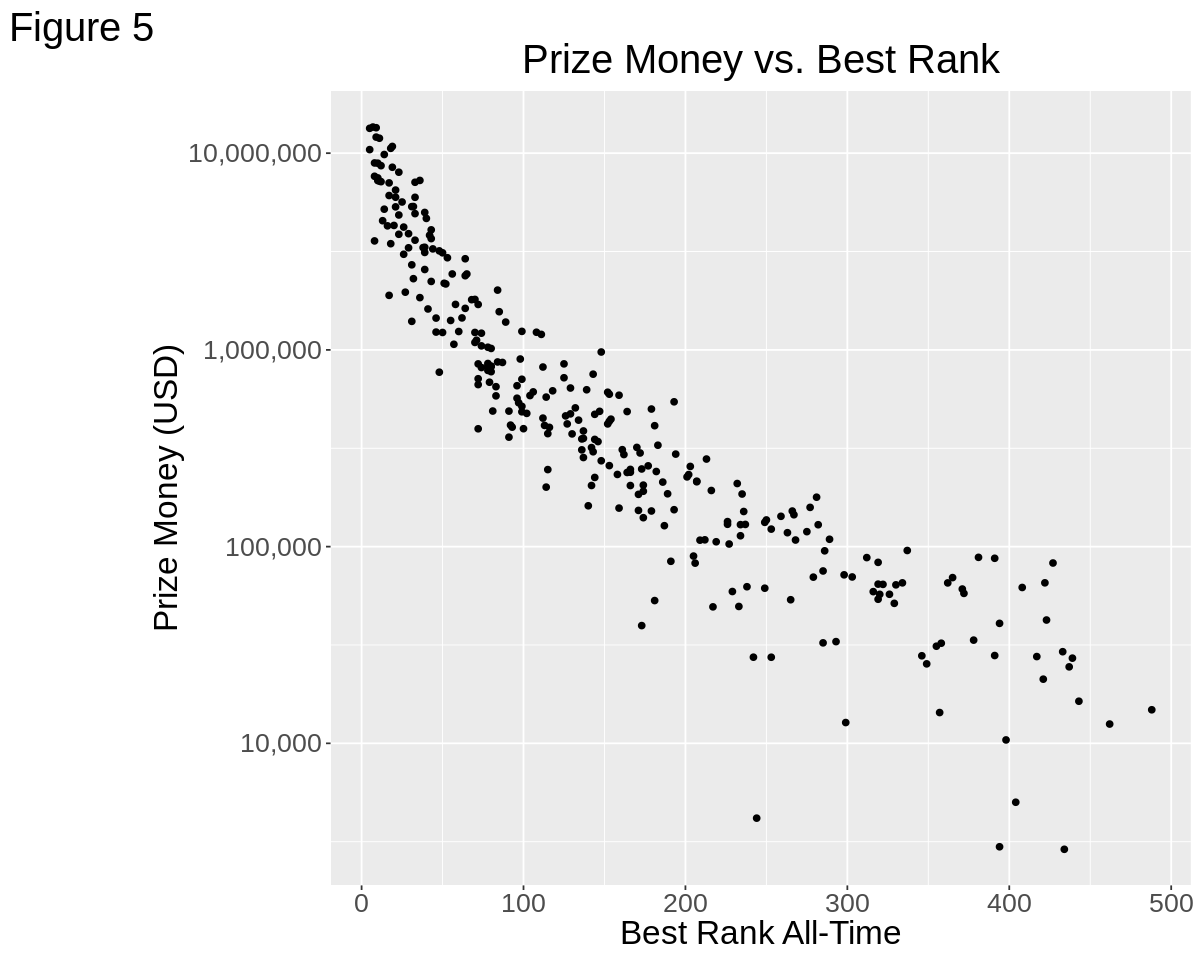

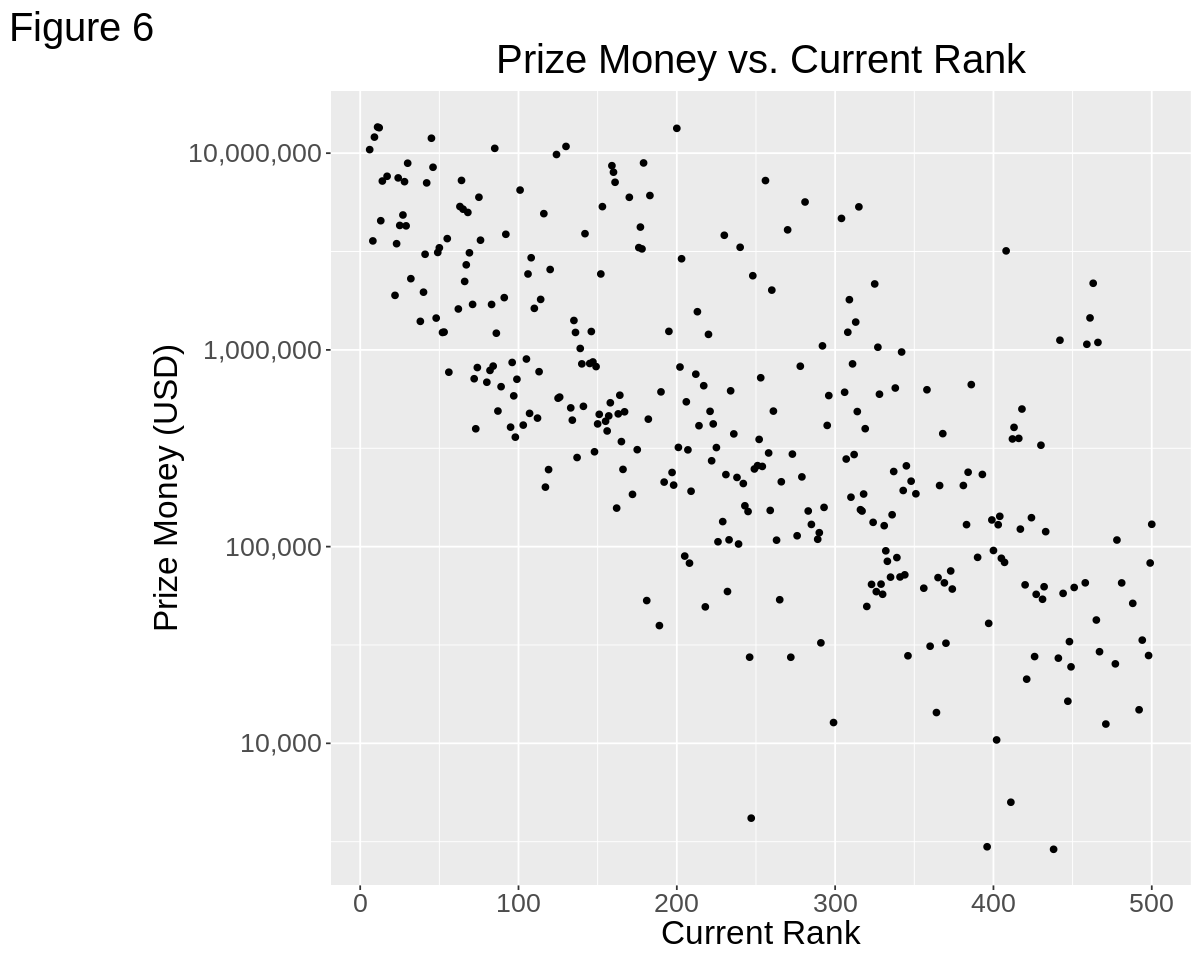

In [185]:
options(repr.plot.height = 8, repr.plot.width = 10)

player_stats_plot_age <- player_stats_training |> 
    ggplot(aes(x = Age, y = Prize_Money)) + 
    geom_point() +
    scale_y_log10(labels = label_comma()) +
    labs(x = "Age", y = "Prize Money (USD)", title = "Prize Money vs. Age", tag = "Figure 4") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
player_stats_plot_age

player_stats_plot_best_rank <- player_stats_training |> 
    ggplot(aes(x = Best_Rank, y = Prize_Money)) + 
    geom_point() +
    scale_y_log10(labels = label_comma()) +
    labs(x = "Best Rank All-Time", y = "Prize Money (USD)", title = "Prize Money vs. Best Rank", tag = "Figure 5") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
player_stats_plot_best_rank

player_stats_plot_current_rank <- player_stats_training |> 
    ggplot(aes(x = Current_Rank, y = Prize_Money)) + 
    geom_point() +
    scale_y_log10(labels = label_comma()) +
    labs(x = "Current Rank", y = "Prize Money (USD)", title = "Prize Money vs. Current Rank", tag = "Figure 6") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
player_stats_plot_current_rank


### Summary Of Visualizations 

<u>Prize Money Vs. Age </u>

There is a weak positive relationship between age and prize money with a rapid increase in total prize money towards the larger ages. This makes sense because older age gives more time to accumulate total prize money. The relationship appears to be linear. However, due to the weak correlation, we will not be using age as a predictor of prize money.

<u>Prize Money Vs. Best rank </u>
    
This graph shows a strong negative relationship between players’ best rank and total prize money won. The relationship appears to be curvilinear, further incentivising us to use knn regression instead of linear regression. The strong relationship suggests that best rank can be used as a good predictor for prize money.

<u>Prize Money Vs. Current rank </u>
    
Similar to the previous scatterplot, this graph shows a negative relationship between current rank and prize money won. However, the relationship is weaker than best rank, yet still relatively robust, allowing us to use current rank as a predictor for prize money. 

### Choosing Our Predictors

Based off the above information we have come to the conclusion that we will be selecting current_rank and best_rank. As they both have a moderate to strong relationship with prize money. Best and current rank are good indicators of performance, which directly translates to winning more tournaments with prize money rewards. 


## Methods

Preliminary exploratory data analysis using plots have shown relationships of differing strengths. Since all variables are on a continuous scale and numerical, we plan on using a regression model to predict total lifetime prize money using the players’ best rank and current rank. We have removed age due to the weak correlation.
<br>

In the kNN modeling, we have split this dataset into training (75%) and testing (25%) sets. Using a 5-fold cross validation and workflow function, we will select the optimal K value (from 1 - 50) with the lowest RMSE. We create the optimal specifications using this k-value (k = 7),  and use it to train our final model. Finally, we test the model’s accuracy on the test set data and compute the RMSPE.
 
We will visualize the final results by creating a scatter plot with our resulting data.

In [186]:
set.seed(1235) # DO NOT CHANGE

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("regression") 

recipe <- recipe(Prize_Money ~ Current_Rank + Best_Rank, data = player_stats_training) |>
       step_scale(all_predictors()) |>
       step_center(all_predictors())

vfold <- vfold_cv(player_stats_training, v = 5, strata = Prize_Money)

workflow <- workflow() |>
       add_recipe(recipe) |>
       add_model(spec) 

gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

results <- workflow |>
    tune_grid(resamples = vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    filter(mean == min(mean))

print("Table 9: Picking Optimal K")
results

k_min <- results |>
          pull(neighbors)

best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

best_fit <- workflow() |>
          add_recipe(recipe) |>
          add_model(best_spec) |>
          fit(data = player_stats_training)

summary <- best_fit |>
           predict(player_stats_testing) |>
           bind_cols(player_stats_testing) |>
           metrics(truth = Prize_Money, estimate = .pred) |>
           filter(.metric == "rmse") 

print("Table 10: Final RMSPE Value")
summary

[1] "Table 9: Picking Optimal K"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,rmse,standard,1263170,5,162068.8,Preprocessor1_Model02


[1] "Table 10: Final RMSPE Value"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1431277


## Visualization of the Analysis

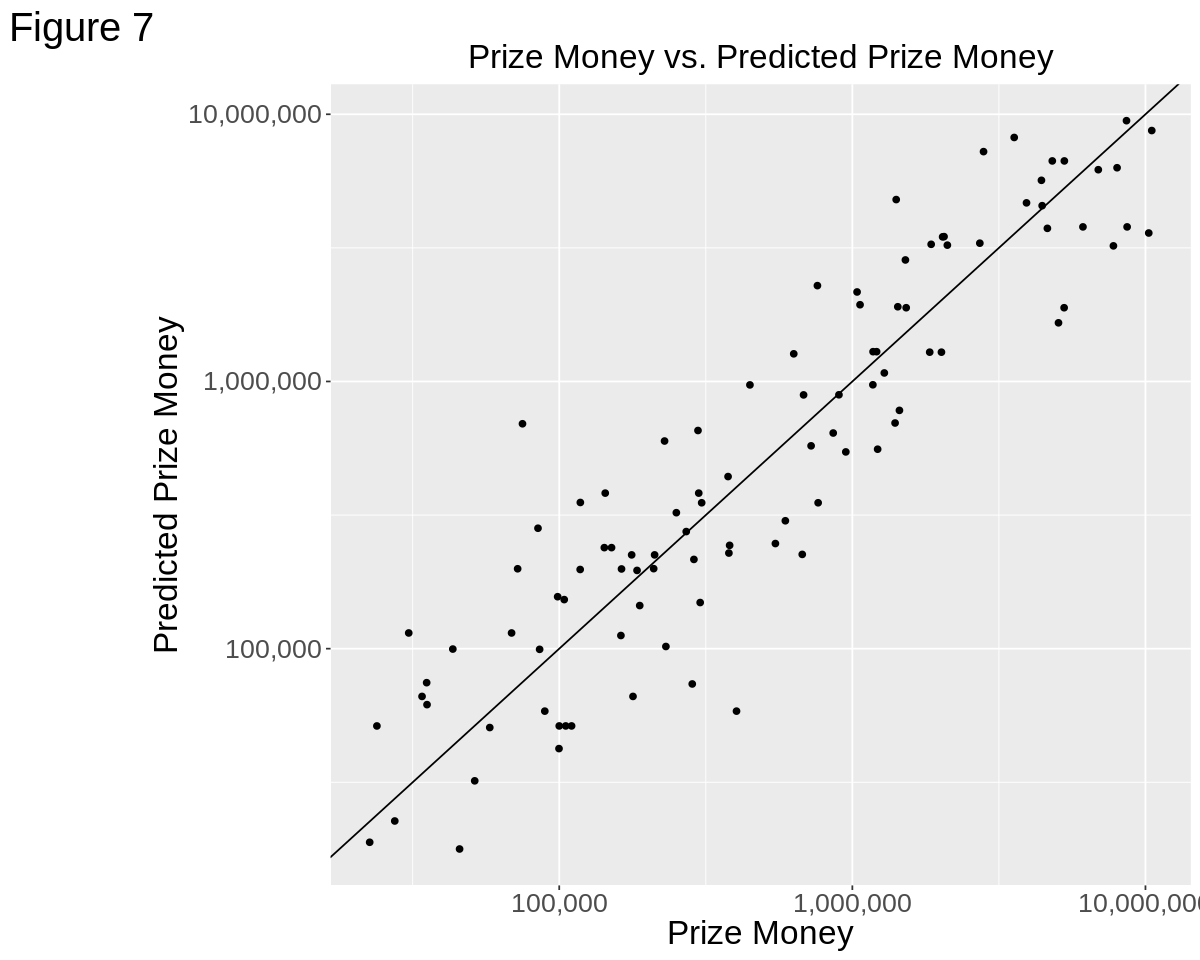

In [187]:
prediction_table <- best_fit |>
           predict(player_stats_testing) |>
           bind_cols(player_stats_testing)

org_vs_pred_plot <- prediction_table |>
    ggplot(aes(x = Prize_Money, y = .pred)) +
    geom_point() +
    geom_abline(slope=1) +
    labs(x = "Prize Money", y = "Predicted Prize Money", tag = "Figure 7") +
    ggtitle("Prize Money vs. Predicted Prize Money")+
    theme(text = element_text(size = 20))+
    theme(plot.title = element_text(size = 20, hjust = 0.5)) + 
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma())
    
org_vs_pred_plot

This graph plots our predicted prize money values against the actual prize money from the testing set. The diagonal from the bottom left to the top right represents 100% accuracy (no prediction error), thus deviations from this show our model’s prediction error. Our predicted and actual values seem to be moderately correlated, indicating that our regression is relatively accurate however, not perfect.

## Discussion 

We found that the predicted prize money based on best rank and current rank has a test error as assessed by RMSPE as 1,431,277 USD. 

This RMSPE value is a decent estimate for prize money won by males in the top 500 of tennis playes. However, the included data does exclude outliers that won prize money for over 100 million USD so the regression model will not provide accurate results for those who won or will win over 100 million USD. 

Also we were able to determine from the 38 variables that best and current rank were the most accurate predictors. Both the RMSPE value and predictors are what we expected to find, because just based off our intuition at the start we choose best and current rank as our predictors variables because those two made the most sense. After our exploratory data analysis we were able to determine we were correct.

We expected to be able to find a good model to fit all the players; however, due to the outliers it would not make for a good prediction model for the majority of participants in this sample. 

The impacts of our findings are as the following:

<li> Help current pro tennis players with financial planning based on their predicted winnings in the future </li>

<li > Help up and coming tennis players predicted to go pro to attract sponsorships and endorsements based on their predicted winnings at their predicted rank </li>

<br> 

Furthermore, we expected to be able to provide the above impacts with our findings, and without the outliers we can ensure that it is much more unlikely for these players to overestimate their potential earnings, further strengthening the significance of our impacts.

The relatively low RMSPE allows us to be confident for the above impacts as the scale for error is 1,431,277 USD and this amount is not highly significant for the millions of dollars these players make for playing the sport.

As higher age allows a longer time period for players to pool up their prize money, further questions can implement age as a factor to perhaps look to find the prime ages where the average pro tennis player makes the most prize money. 




## Legend 

Tables:
1. Player Stats head
2. Number of NAs per Variables
3. Number of Numerical Variable NAs (head)
4. Number of Numerical Variable NAs (tail)
5. Player Stats Tidy Data Frame
6. Max Prize Money
7. Min Prize Money
8. Average Total Prize Money Won for every Age Group
9. Picking Optimal K
10. Final RMSPE Value

Figures:
1. Full Plot Distribution of Prize Money
2. Limited Plot Plot Distribution of Prize Money
3. Average Total Prize Money Won for every Age Group
4. Prize Money Vs. Age
5. Prize Money Vs. Best Rank
6. Prize Money Vs. Current Rank
7. Prize Money vs. Predicted Prize Money


## References
1. How Many People Watch Tennis? [Tennis Viewership Statistics 2023]. Published May 26, 2023. Accessed June 22, 2023. https://playtoday.co/blog/stats/tennis-viewership-statistics/

2. Nair D. The Best Sources for Tennis Player Stats and Match Insights. Racquet Social. Published August 15, 2020. Accessed June 22, 2023. https://racquetsocial.com/six-sources-for-tennis-stats-and-insights/

3. Ultimate Tennis Statistics. Accessed June 22, 2023. https://www.ultimatetennisstatistics.com/